# Remote Timing Attacks are Practical
_Experiment 6: Attacking SSL applications on the local network._

---

In [1]:
import scipy
import scipy.signal
import seaborn
import sympy
import numpy
import pandas
import os
import matplotlib.pyplot as plt

from IPython import display
from pprint import pprint

In [2]:
import tls
import attack

In [3]:
%matplotlib notebook
PLOT_KWARGS = {
    "height": 4.5, 
    "aspect": 16/8, 
}

## Theory

In [4]:
p = sympy.Integer(11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789)
q = sympy.Integer(11353860437120204348539420361367294927683441924641720282978666316144621735920188475867378638813811676070362003602263559496393696538309271007870774914687283)
N = sympy.Integer(132762152776056020551326919245624484615462467876809681535549565118332290525598572815747323476102181376625279228965473106140757139049665124368186142774966643990206422037551427526013151129106319233128471783533673959766053786798472937188481868923726256436384468384858420931063093337134977283618537887974322079287)

## Bruteforce Top Few Bits of $q$
The aim of this notebook is to sample the server response times for a bunch of `g` values, and find out if the distribution is meaningfully different between them.

In [5]:
NEIGHBOURHOOD_SIZE = 400
SAMPLE_SIZE = 10
BRUTEFORCED_BITS = 4

filename = "./measurements/bruteforce-top-bits.txt"
if not os.path.exists(filename):
    gs = attack.bruteforce_most_significant_bits(num_bits=BRUTEFORCED_BITS)
    
    print("Taking {} samples...".format(len(gs)*SAMPLE_SIZE*NEIGHBOURHOOD_SIZE))
    
    raw_samples = attack.sample(
        gs,
        sample_size=SAMPLE_SIZE,
        neighbourhood_size=NEIGHBOURHOOD_SIZE,
        u_g=True,
        N=N,
    )
    samples = pandas.DataFrame.from_records(
        raw_samples,
        columns=["point", "time"],
    )
    samples.to_csv(filename, sep=" ")

else:
    samples = pandas.read_csv(
        filename,
        sep=" ",
        usecols=["point", "time"],
    )

samples['point'] = samples['point'].apply(sympy.Integer)
samples

,point,time
0,6703903964971298549787012499102923063739682910...,3873643
1,6703903964971298549787012499102923063739682910...,3643492
2,6703903964971298549787012499102923063739682910...,3638309
3,6703903964971298549787012499102923063739682910...,3710111
4,6703903964971298549787012499102923063739682910...,3721465
...,...,...
31995,1256981993432118478085064843581798074451190545...,3632438
31996,1256981993432118478085064843581798074451190545...,3712435
31997,1256981993432118478085064843581798074451190545...,3752991
31998,1256981993432118478085064843581798074451190545...,3627998


In the paper, they take median time for each point. By taking the minimum, I hope to extract the fastest time possible, which should be the time with minimal context switches and other delays. This works provided the only sources of unwanted noise _add time_ (rather than remove it).

In [6]:
samples = samples.groupby(by="point").median().reset_index()
samples

,point,time
0,6703903964971298549787012499102923063739682910...,3640923.0
1,6703903964971298549787012499102923063739682910...,3668430.5
2,6703903964971298549787012499102923063739682910...,3646574.5
3,6703903964971298549787012499102923063739682910...,3716786.0
4,6703903964971298549787012499102923063739682910...,3636828.0
...,...,...
3195,1256981993432118478085064843581798074451190545...,3637174.0
3196,1256981993432118478085064843581798074451190545...,3700477.5
3197,1256981993432118478085064843581798074451190545...,3665147.0
3198,1256981993432118478085064843581798074451190545...,3701185.0


We can group samples into their respective "neighbourhoods" considering their most significant bits only.

In [7]:
def point_to_neighbourhood(point):
    point_int = sympy.Integer(point)
    point_bits = attack.sympy_integer_to_bits(point_int)
    neighbourhood_point_bits = point_bits[0:BRUTEFORCED_BITS] + [0] * (512-BRUTEFORCED_BITS)
    neighbourhood_point_int = attack.bits_to_sympy_integer(neighbourhood_point_bits)
    return neighbourhood_point_int

samples['neighbourhood'] = samples['point'].apply(point_to_neighbourhood)

Sum together the measurements in each neighbourhood:

In [8]:
samples = samples.groupby(by="neighbourhood").sum().reset_index()
samples

,neighbourhood,time
0,6703903964971298549787012499102923063739682910...,1.464391e+09
1,7541891960592710868510389061490788446707143274...,1.463392e+09
2,8379879956214123187233765623878653829674603637...,1.463324e+09
3,9217867951835535505957142186266519212642064001...,1.464078e+09
4,1005585594745694782468051874865438459560952436...,1.464982e+09
5,1089384394307836014340389531104224997857698472...,1.464240e+09
6,1173183193869977246212727187343011536154444509...,1.463615e+09
7,1256981993432118478085064843581798074451190545...,1.465066e+09


Since we know the factors of `N` (`q` and `p` with `q<p`) we can consider each point relative in size to these factors. When plotting, we are looking for peaks and troughs near whole multples of `p` and `q`.

In [9]:
sqrt_N = sympy.sqrt(N)
samples['point_relative_to_sqrt_n'] = samples['neighbourhood'].apply(lambda g: round(float(g/sqrt_N), 10))
samples

,neighbourhood,time,point_relative_to_sqrt_n
0,6703903964971298549787012499102923063739682910...,1.464391e+09,0.581823
1,7541891960592710868510389061490788446707143274...,1.463392e+09,0.654551
2,8379879956214123187233765623878653829674603637...,1.463324e+09,0.727278
3,9217867951835535505957142186266519212642064001...,1.464078e+09,0.800006
4,1005585594745694782468051874865438459560952436...,1.464982e+09,0.872734
5,1089384394307836014340389531104224997857698472...,1.464240e+09,0.945462
6,1173183193869977246212727187343011536154444509...,1.463615e+09,1.018190
7,1256981993432118478085064843581798074451190545...,1.465066e+09,1.090918


In [10]:
q_relative_to_sqrt_n = round(float(q/sqrt_N), 10)
p_relative_to_sqrt_n = round(float(p/sqrt_N), 10)

Now plot the media response time as we vary `g`:

In [11]:
smallest_time_observed = samples['time'].min()
largest_time_observed = samples['time'].max()

buffer = (largest_time_observed - smallest_time_observed)/10

smallest_time_observed, largest_time_observed, buffer

(1463324168.5, 1465065975.0, 174180.65)

In [12]:
if SAMPLE_SIZE == 20 and NEIGHBOURHOOD_SIZE == 800:
    error = 27442/(2*6529841)
elif SAMPLE_SIZE == 7 and NEIGHBOURHOOD_SIZE == 400:
    error = 42987/(2*6500856)
else:
    error = 0

In [13]:
ylim = (
    smallest_time_observed * (1 - error) - buffer,
    largest_time_observed * (1 + error) + buffer,
)

<IPython.core.display.Javascript object>


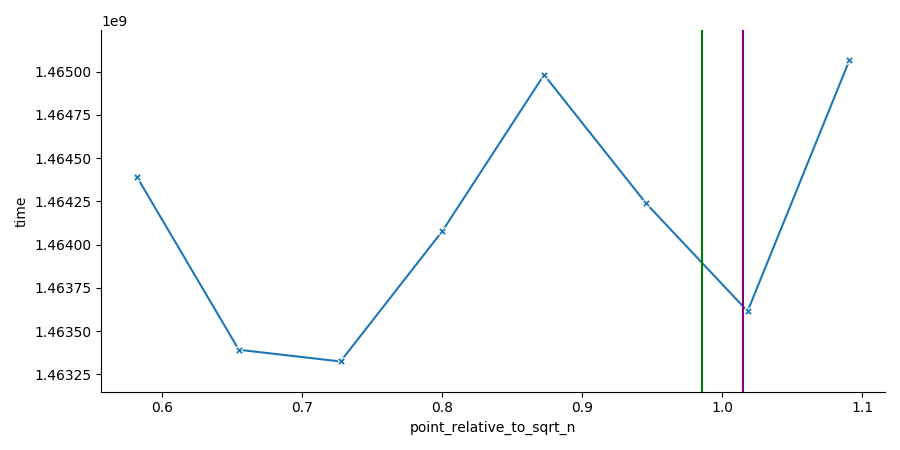

In [14]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', marker="X", **PLOT_KWARGS)
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

In the section below, we bound the value of $q$ using the shape of this graph. But its worth noting that the peaks and troughs in the graphs above fit well inside the error bars (calculated in the `noise.ipynb` notebook). It is likely this graph should just be a straight line. 

### Bounding our search for `q`

`scipy` finds two peaks in the sample set.

In [15]:
peak_indices, _ = scipy.signal.find_peaks(samples['time'])
len(peak_indices)

1

Lets re-plot the above graph with the peaks highlighted:

<IPython.core.display.Javascript object>


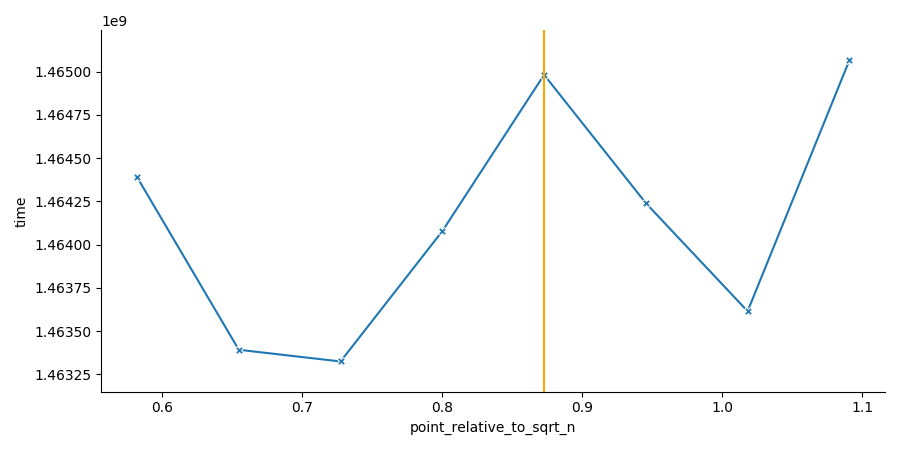

In [16]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', marker="X", **PLOT_KWARGS)

for peak_index in peak_indices:
    peak = samples.iloc[peak_index]
    plt.plot([peak['point_relative_to_sqrt_n'], peak['point_relative_to_sqrt_n']], ylim, color='orange')

if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

I'm going to cheat a little and say that: we should always pick the peak closest to, but less than, $\sqrt{N}$. Why? We are looking for the peak that gives a lower bound on $q$. After the peak, the number of Montgomery reductions should dip significantly. It will slowly rise until it hits $p$, where it will immediately dip significantly again. We know that $q < \sqrt{n} < p$, so there shouldn't be any peaks in the interval $(q, p)$. Therefore, the peak closest to, but less than, $\sqrt{N}$ is the peak caused by the dip in Montgomery  reductions when $g = q$.

In [17]:
for peak_index in peak_indices:
    peak_row = samples.iloc[peak_index]
    peak_g = peak_row['neighbourhood']
    
    if peak_g > sqrt_N:
        peak_index = previous_peak_index
        peak_row = samples.iloc[peak_index]
        peak_g = peak_row['neighbourhood']
        break
        
    previous_peak_index = peak_index
        
peak_row

neighbourhood               1005585594745694782468051874865438459560952436...
time                                                              1.46498e+09
point_relative_to_sqrt_n                                             0.872734
Name: 4, dtype: object

In [18]:
attack.sympy_integer_to_bits(peak_g)[0:BRUTEFORCED_BITS]

[1, 1, 0, 0]

This gives a lower bound on `q`. To get an upper bound on `q`, note the following:
  1. $q*p = N$
  2. $q < p$

From 1. and 2. it follows that $q < \sqrt{N}$.

(Suppose $q >= \sqrt{N}$, then by 2. $p > \sqrt{N}$ and so $ q*p > N$ which contradicts 1. Therefore $q < \sqrt{N}$.)

In [19]:
lower_bound = peak_g
upper_bound = sympy.Integer(sqrt_N.round())

lower_bound, upper_bound

(10055855947456947824680518748654384595609524365444295033292671082791323022555160232601405723625177570767523893639864538140315412108959927459825236754563072,
 11522245995293453226444537667133610590574234209345464522156603069988519317090416103523895551843843150180734266788088596830720220822331432054108383719953516)

Let's plot these two bounds on the graph:

<IPython.core.display.Javascript object>


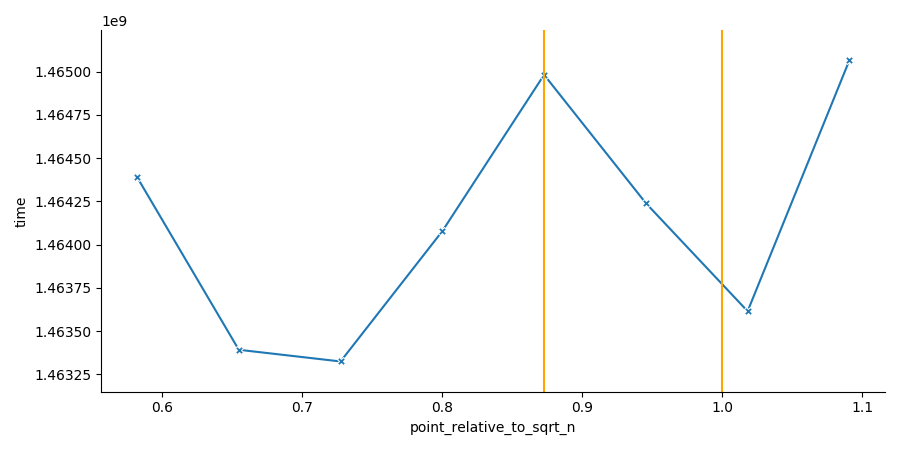

In [20]:
lower_bound_relative_to_sqrt_n = round(float(lower_bound/sqrt_N), 10)
upper_bound_relative_to_sqrt_n = round(float(upper_bound/sqrt_N), 10)

g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', marker="X", **PLOT_KWARGS)

plt.plot([lower_bound_relative_to_sqrt_n, lower_bound_relative_to_sqrt_n], ylim, color='orange')
plt.plot([upper_bound_relative_to_sqrt_n, upper_bound_relative_to_sqrt_n], ylim, color='orange')

if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

Lets consider the bit representations of these two bounds so we can set in stone the first few bits.

In [21]:
print("Lower Bound:", attack.sympy_integer_to_bits(lower_bound)[0:BRUTEFORCED_BITS])
print("Upper Bound:", attack.sympy_integer_to_bits(upper_bound)[0:BRUTEFORCED_BITS])

Lower Bound: [1, 1, 0, 0]
Upper Bound: [1, 1, 0, 1]


In [22]:
lower_bound_bits = attack.sympy_integer_to_bits(lower_bound)
upper_bound_bits = attack.sympy_integer_to_bits(upper_bound)

known_q_bits = []
for i in range(BRUTEFORCED_BITS):
    if lower_bound_bits[i] == upper_bound_bits[i]:
        known_q_bits.append(lower_bound_bits[i])
    else:
        break
        
known_q_bits

[1, 1, 0]

The above giving us the first bits of $q$. We should have recovered `BRUTEFORCED_BITS=4` bits but only found the first 3 were common among the lower and upper bounds. This is because our measurement for the point at $\text{point_relative_to_sqrt_n}  \approx 0.945$ should have been higher than the peak we've found. The dip in the point between the lower bound a `q` shouldn't exist, that point should be higher (in my understanding). This indicates that we haven't triggered the bug, or we are measuring the wrong thing.

Since it is prime, we also know that $q$ is odd, and so its least significant bit is 1. We'll ignore that for now.

# Recovering Bits of $q$

Run the iterative key recovery attack on bits 1, 2, and 3. We already know their true values, so there zero-one gaps can be used as reference points for the other bits.

In [23]:
q_bits = attack.sympy_integer_to_bits(q)

In [24]:
BITS_TO_RECOVER = 25
bit_samples_filename = "./measurements/bit-samples.txt"

In [25]:
if not os.path.exists(bit_samples_filename):
    bit_samples = pandas.DataFrame({
        'bit_position': [],
        'bit_value': [],
        'point': [],
        'time': [],
    })

    bits = []
    for i in range(0, BITS_TO_RECOVER):
        g_low_samples, g_high_samples = attack.sample_ith_bit(
            q_bits,
            i,
            sample_size=SAMPLE_SIZE,
            neighbourhood_size=NEIGHBOURHOOD_SIZE,
        )

        g_low_samples['bit_position'] = i
        g_low_samples['bit_value'] = 0

        g_high_samples['bit_position'] = i
        g_high_samples['bit_value'] = 1

        bit_samples = pandas.concat([bit_samples, g_low_samples, g_high_samples], axis=0, sort=True)

    bit_samples.to_csv(bit_samples_filename, sep=" ")

In [26]:
bit_samples = pandas.read_csv(bit_samples_filename, sep=" ").drop("Unnamed: 0", axis=1)
bit_samples

,bit_position,bit_value,point,time
0,0.0,0.0,0,515528.0
1,0.0,0.0,0,504498.0
2,0.0,0.0,0,510940.0
3,0.0,0.0,0,510360.0
4,0.0,0.0,0,503782.0
...,...,...,...,...
199995,24.0,1.0,1135386041403096591370322569353567141661393965...,3707329.0
199996,24.0,1.0,1135386041403096591370322569353567141661393965...,3725922.0
199997,24.0,1.0,1135386041403096591370322569353567141661393965...,3643090.0
199998,24.0,1.0,1135386041403096591370322569353567141661393965...,3650421.0


Next, collate the sample sets and neighbourhoods to provide a single measurement for each bit position and value combination.

In [27]:
bit_timings = bit_samples\
    .groupby(["bit_position", "bit_value", "point"]).median()\
    .groupby(["bit_position", "bit_value"]).sum()\
    .reset_index()

bit_timings

,bit_position,bit_value,time
0,0.0,0.0,1.462552e+09
1,0.0,1.0,1.465466e+09
2,1.0,0.0,1.464756e+09
3,1.0,1.0,1.464819e+09
4,2.0,0.0,1.465904e+09
5,2.0,1.0,1.465578e+09
6,3.0,0.0,1.465916e+09
7,3.0,1.0,1.463904e+09
8,4.0,0.0,1.464815e+09
9,4.0,1.0,1.465603e+09


To replicate the paper, we calculate the zero-one gap for each bit position:

In [28]:
def calc_zero_one_gap(row):
    T_g_low = row[row['bit_value']==0]['time'].iloc[0]
    T_g_high = row[row['bit_value']==1]['time'].iloc[0]
    return abs(T_g_low-T_g_high)

zero_one_gaps = bit_timings.groupby("bit_position").apply(calc_zero_one_gap)
zero_one_gaps

bit_position
0.0      2914368.5
1.0        62873.5
2.0       326615.0
3.0      2011929.5
4.0       788008.5
5.0       523160.5
6.0       718806.0
7.0       355099.0
8.0      5834700.5
9.0       379164.0
10.0      240788.0
11.0       28537.0
12.0      984747.5
13.0      282233.5
14.0      983935.5
15.0     1497770.0
16.0      273896.5
17.0     5200060.0
18.0      303358.0
19.0    11767432.0
20.0     1102531.0
21.0     1646728.0
22.0     3264793.5
23.0     1521040.5
24.0      378493.0
dtype: float64

Plot the gap for each bit position, with a color to denote its true value. Can we separate these into two distinct distributions?

<IPython.core.display.Javascript object>


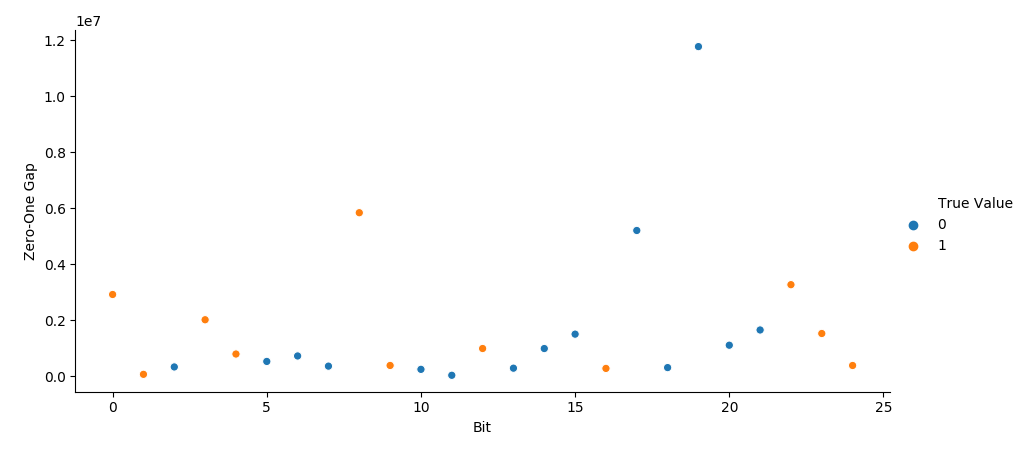

In [29]:
seaborn.relplot(
    data=pandas.DataFrame({
        'True Value': q_bits[0:BITS_TO_RECOVER],
        'Zero-One Gap': zero_one_gaps,
        'Bit': range(0, BITS_TO_RECOVER),
    }),
    x='Bit',
    y='Zero-One Gap',
    hue='True Value',
    kind='scatter',
    **PLOT_KWARGS,
)

These results aren't great. Plotting the zero-one gaps shows that there isn't a consistent way of separating them. Further, the first 4 bits show the opposite pattern to the one we'd expect.

To investigate, I plot the timings for each point in a graph similar to the one in ["Bruteforce Top Few Bits of $q$"](#Bruteforce-Top-Few-Bits-of-$q$). Do the points follow the expected shape?

In [31]:
def calc_point(row):
    bit_position, bit_value = int(row['bit_position']), int(row['bit_value'])
    point_bits = q_bits[0:bit_position] + [bit_value] + [0]*(len(q_bits) - 1 - bit_position)
    point = attack.bits_to_sympy_integer(point_bits)
    return point

bit_timings['neighbourhood'] = bit_timings.apply(calc_point, axis=1)

bit_timings

,bit_position,bit_value,time,neighbourhood
0,0.0,0.0,1.462552e+09,0
1,0.0,1.0,1.465466e+09,6703903964971298549787012499102923063739682910...
2,1.0,0.0,1.464756e+09,6703903964971298549787012499102923063739682910...
3,1.0,1.0,1.464819e+09,1005585594745694782468051874865438459560952436...
4,2.0,0.0,1.465904e+09,1005585594745694782468051874865438459560952436...
5,2.0,1.0,1.465578e+09,1173183193869977246212727187343011536154444509...
6,3.0,0.0,1.465916e+09,1005585594745694782468051874865438459560952436...
7,3.0,1.0,1.463904e+09,1089384394307836014340389531104224997857698472...
8,4.0,0.0,1.464815e+09,1089384394307836014340389531104224997857698472...
9,4.0,1.0,1.465603e+09,1131283794088906630276558359223618267006071491...


In [32]:
bit_timings = bit_timings.groupby('neighbourhood').mean()
bit_timings = bit_timings.reset_index()
bit_timings['point_relative_to_sqrt_n'] = bit_timings['neighbourhood'].apply(lambda g: (g/sqrt_N).evalf(50))
bit_timings

,neighbourhood,bit_position,bit_value,time,point_relative_to_sqrt_n
0,0,0.0,0.000000,1.462552e+09,0
1,6703903964971298549787012499102923063739682910...,0.5,0.500000,1.465111e+09,0.58182267308905522192424288413716149784674078...
2,1005585594745694782468051874865438459560952436...,2.0,0.333333,1.465546e+09,0.87273400963358283288636432620574224677011118...
3,1089384394307836014340389531104224997857698472...,3.5,0.500000,1.464360e+09,0.94546184376971473562689468672288743400095378...
4,1131283794088906630276558359223618267006071491...,6.0,0.200000,1.465857e+09,0.98182576083778068699715986698146002761637508...
5,1133902506575223543772568910981080346327844804...,8.5,0.500000,1.464284e+09,0.98409850565453480895780144074762081471733891...
6,1135211862818382000520574186859811385988731461...,10.5,0.250000,1.465283e+09,0.98523487806291186993812222763070120826782082...
7,1135375532348776807614074846344652765946342293...,14.0,0.200000,1.465005e+09,0.98537692461395900256066232599108625746163106...
8,1135385761694426483057418637562455352193692970...,19.0,0.142857,1.465670e+09,0.98538580252339944834957108213861032303624420...
9,1135385921527952259236220884300233517603807825...,22.5,0.500000,1.465576e+09,0.98538594124073445531502278145341538656084753...


The points we are plotting come from a binary search, where we correctly "guessed" the direction at each bit position. It's worth using the interactive features to zoom in close and get a better understanding of how the decryption time behaves close to `q`.

<IPython.core.display.Javascript object>


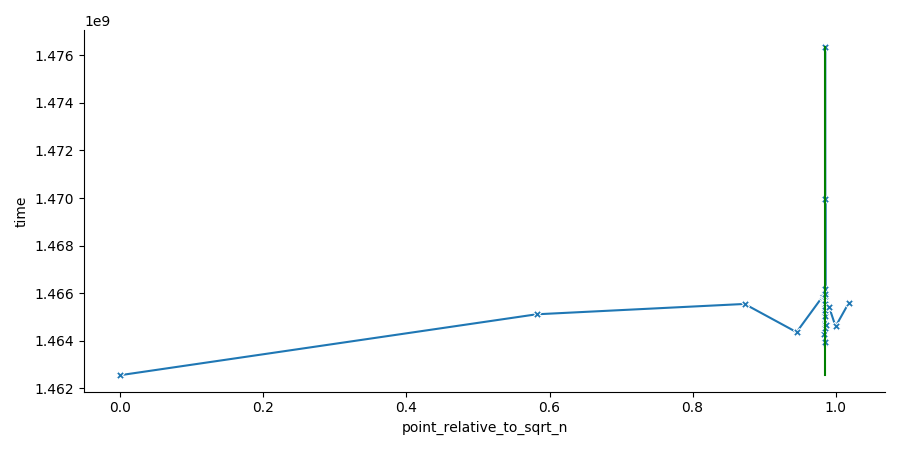

In [33]:
g = seaborn.relplot(
    data=bit_timings, 
    x='point_relative_to_sqrt_n', 
    y='time',
    kind='line',
    marker="X",
    **PLOT_KWARGS,
)
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [bit_timings['time'].min(), bit_timings['time'].max()], color='green')
g

This doesn't look too promising. As above, this doesn't look like we've triggered the bug.

## Coppersmiths Attack

## References
  - [1] https://crypto.stanford.edu/~dabo/papers/ssl-timing.pdf